<a href="https://colab.research.google.com/github/grillinr/evolutionary-computing/blob/main/final/final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries and seed for easier checking

In [1]:
import random
import os
import argparse
import math
from typing import List, Tuple


import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


SEED = 5173
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
print(device)

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

cuda


# Define helper functions

In [2]:
def prepare_data_with_scaler(data, scaler=None, fit=False):
    data = data.dropna()
    X = data.drop(columns=["id", "record", "type"]).values.astype(np.float32)
    y = data["type"].astype("category").cat.codes.values

    if fit:
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


def evaluate(model, X, y, criterion):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        loss = criterion(logits, y)
        y_pred = logits.argmax(dim=1).cpu().numpy()

    y_true = y.cpu().numpy()
    return {
        "loss": loss.item(),
        "accuracy": accuracy_score(y_true, y_pred),
        "f_beta_macro": fbeta_score(y_true, y_pred, average="macro", beta=2, zero_division=0)
    }


def estimate_flops(model, input_shape):
    """
    Estimate FLOPs for Linear and Conv2d layers only.
    Args:
        model (nn.Module): PyTorch model
        input_shape (tuple): shape of one input sample, e.g., (1, 3, 224, 224) or (1, input_dim)
    Returns:
        total_flops (int)
    """
    flops = 0

    def count_layer(layer, x_in, x_out):
        nonlocal flops
        # Conv2d FLOPs = Kx * Ky * Cin * Cout * Hout * Wout
        if isinstance(layer, nn.Conv2d):
            out_h, out_w = x_out.shape[2:]
            kernel_ops = layer.kernel_size[0] * layer.kernel_size[1]
            flops += kernel_ops * layer.in_channels * layer.out_channels * out_h * out_w
        # Linear FLOPs = input_features * output_features
        elif isinstance(layer, nn.Linear):
            flops += layer.in_features * layer.out_features

    hooks = []
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            hooks.append(layer.register_forward_hook(count_layer))

    dummy = torch.randn(input_shape).to(next(model.parameters()).device)
    with torch.no_grad():
        model(dummy)

    for h in hooks:
        h.remove()

    return flops

# Create Model Architecture (DNN)

In [3]:
class DNN(nn.Module):
    def __init__(self, input_size=32, hidden=(32, 16, 8), num_classes=5, dropout_rate=0.5):
        super().__init__()
        layers = []
        input_dim = input_size

        for h in hidden:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(dropout_rate))
            input_dim = h

        layers.append(nn.Linear(input_dim, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Main Training loop

In [5]:
# Load data
dataset = pd.read_csv("/content/train.csv")
train_dataset, val_dataset = train_test_split(dataset, train_size=0.7, random_state=SEED)
scaler = StandardScaler()
X_train, y_train = prepare_data_with_scaler(train_dataset, scaler, fit=True)
X_val, y_val = prepare_data_with_scaler(val_dataset, scaler, fit=False)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

In [16]:
# Configuration
class Hyperparameters:
    def __init__(self, lr, epochs, hidden, dropout_rate, patience):
        self.lr = lr
        self.epochs = epochs
        self.hidden = hidden
        self.dropout_rate = dropout_rate
        self.patience = patience

    def __repr__(self):
        return f"Hyperparameters(lr={self.lr}, epochs={self.epochs}, hidden={self.hidden}, dropout_rate={self.dropout_rate}, patience={self.patience})"

    def __str__(self):
        return self.__repr__()

In [7]:
def train(params: Hyperparameters):
  # Create model
  model = DNN(hidden=params.hidden, dropout_rate=params.dropout_rate).to(device)

  class_counts = train_dataset['type'].value_counts()
  weights = 1.0 / class_counts.values
  weights = torch.FloatTensor(weights).to(device)
  criterion = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.Adam(model.parameters(), lr=params.lr)

  # Training loop with early stopping
  best_val_loss = float('inf')
  patience_counter = 0
  epochs_run = params.epochs
  for epoch in range(1, params.epochs + 1):
      model.train()
      optimizer.zero_grad()
      out = model(X_train)
      loss = criterion(out, y_train)
      loss.backward()
      optimizer.step()
      train_loss = loss.item()

      train_metrics = evaluate(model, X_train, y_train, criterion)
      val_metrics = evaluate(model, X_val, y_val, criterion)

      if epoch % (params.epochs // 10) == 0:
        print(
            f"Epoch {epoch}/{params.epochs} | "
            f"train_loss={train_loss:.4f} train_acc={train_metrics['accuracy']:.4f} "
            f"train_f1={train_metrics['f_beta_macro']:.4f} "
            f"val_loss={val_metrics['loss']:.4f} val_acc={val_metrics['accuracy']:.4f} "
            f"val_f1={val_metrics['f_beta_macro']:.4f} "
        )

      # Early stopping check
      if val_metrics['loss'] < best_val_loss:
          best_val_loss = val_metrics['loss']
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= params.patience:
              print(f"Early stopping at epoch {epoch}")
              epochs_run = epoch
              break

  # Return a tuple of fitness values for domination comparison
  # Maximize accuracy, f1, and minimize loss, flops.
  # For loss and flops, we take the negative value.
  return (val_metrics["accuracy"], val_metrics["f_beta_macro"], -val_metrics["loss"], -estimate_flops(model, (1, 32)))

In [17]:
# Test the function
hyperparameters = Hyperparameters(lr=1e-3, epochs=500, hidden=(64, 32, 16, 8), dropout_rate=0.5, patience=100)
# result = train(hyperparameters)

# Neuroevolution

In [8]:
def init_population(pop_size: int) -> List[Hyperparameters]:
    population = []
    for _ in range(pop_size):
        lr = random.uniform(1e-5, 1e-1)
        epochs = random.randint(10, 200)

        # Generate variable-length hidden layer tuple
        num_layers = random.randint(1, 5)
        hidden = tuple(2 ** random.randint(3, 8) for _ in range(num_layers))

        dropout_rate = random.uniform(0.0, 0.5)
        patience = random.randint(5, 30)

        population.append(Hyperparameters(lr, epochs, hidden, dropout_rate, patience))

    return population

In [9]:
def count_dominated(fitnesses: List[Tuple[float, ...]], idx: int) -> int:
    """Count how many points are dominated by fitnesses[idx]"""
    point = fitnesses[idx]
    dominated = 0
    for other in fitnesses:
        if other == point:
            continue
        # Check if point dominates other (all >= and at least one >)
        if all(p >= o for p, o in zip(point, other)) and any(p > o for p, o in zip(point, other)):
            dominated += 1
    return dominated

## Define Evolution Strategy to Optimize Hyperparameters

In [14]:
def evolution_strategy(mu: int, lambda_: int, tau: float, max_gens: int) -> List[Hyperparameters]:
    population = init_population(mu)

    for generation_number in range(1, max_gens + 1):
        print(f"Generation {generation_number} starting initial evaluation")
        fitnesses = []
        for i, member in enumerate(population):
            print(f"Evaluating member {i}: {member}")
            fitnesses.append(train(member))

        # fitnesses = [train(member) for member in population]

        # Calculate proportion of dominated points for each individual
        domination_counts = [count_dominated(fitnesses, i) for i in range(mu)]
        domination_proportions = [count / mu for count in domination_counts]

        offspring = []
        for _ in range(lambda_):
            # Select parent using tournament based on domination proportion
            candidates = random.sample(range(mu), 2)
            parent_idx = max(candidates, key=lambda i: domination_proportions[i])
            parent = population[parent_idx]

            # Mutate hyperparameters
            lr = parent.lr * math.exp(tau * random.gauss(0.0, 1.0))
            lr = max(1e-5, min(1e-1, lr))

            epochs = int(parent.epochs + random.gauss(0.0, 10))
            epochs = max(10, min(500, epochs))

            # Mutate hidden layers
            hidden = list(parent.hidden)
            if random.random() < 0.3:
                if len(hidden) > 1 and random.random() < 0.5:
                    hidden.pop(random.randrange(len(hidden)))
                elif len(hidden) < 5:
                    hidden.insert(random.randrange(len(hidden) + 1), 2 ** random.randint(3, 8))
            else:
                idx = random.randrange(len(hidden))
                hidden[idx] = max(8, min(256, int(hidden[idx] + random.gauss(0.0, 16))))

            dropout_rate = parent.dropout_rate + random.gauss(0.0, 0.05)
            dropout_rate = max(0.0, min(0.5, dropout_rate))

            patience = int(parent.patience + random.gauss(0.0, 3))
            patience = max(5, min(30, patience))

            offspring.append(Hyperparameters(lr, epochs, tuple(hidden), dropout_rate, patience))

        offspring_fitnesses = [train(member) for member in offspring]

        # Calculate domination for offspring
        offspring_domination_counts = [count_dominated(offspring_fitnesses, i) for i in range(lambda_)]
        offspring_domination_proportions = [count / lambda_ for count in offspring_domination_counts]

        # Logging
        best_idx = max(range(mu), key=lambda i: domination_proportions[i])
        print(f"Gen {generation_number} Best: {fitnesses[best_idx]}")

        # Select best member from offspring based on domination
        indexed = [(prop, i) for i, prop in enumerate(offspring_domination_proportions)]
        indexed.sort(key=lambda x: x[0], reverse=True)

        population = [offspring[i] for _, i in indexed[:mu]]

    return population

In [18]:
final_pop = evolution_strategy(mu=10, lambda_=10, tau=0.05, max_gens=10)
for member in final_pop:
    print(member)

Generation 1 starting initial evaluation
Evaluating member 0: Hyperparameters(lr=0.04779887398429091, epochs=148, hidden=(64, 32, 64, 256), dropout_rate=0.19037090294267395, patience=14)
Epoch 14/148 | train_loss=0.7306 train_acc=0.0676 train_f1=0.0532 val_loss=0.6898 val_acc=0.0676 val_f1=0.0532 
Epoch 28/148 | train_loss=0.5724 train_acc=0.0676 train_f1=0.0532 val_loss=0.4762 val_acc=0.0676 val_f1=0.0532 
Epoch 42/148 | train_loss=0.5017 train_acc=0.8950 train_f1=0.3388 val_loss=0.3891 val_acc=0.8961 val_f1=0.3393 
Epoch 56/148 | train_loss=0.4836 train_acc=0.9032 train_f1=0.3433 val_loss=0.3681 val_acc=0.9046 val_f1=0.3438 
Epoch 70/148 | train_loss=0.4701 train_acc=0.9100 train_f1=0.3474 val_loss=0.3516 val_acc=0.9112 val_f1=0.3479 
Epoch 84/148 | train_loss=0.4677 train_acc=0.9049 train_f1=0.3442 val_loss=0.3418 val_acc=0.9065 val_f1=0.3451 
Epoch 98/148 | train_loss=0.4609 train_acc=0.9121 train_f1=0.3480 val_loss=0.3311 val_acc=0.9133 val_f1=0.3486 
Epoch 112/148 | train_loss=0.

# Test output

In [20]:
# Stats for final generation
final_pop_stats = [train(member) for member in final_pop]
print(final_pop_stats)

Epoch 16/168 | train_loss=0.4785 train_acc=0.8971 train_f1=0.3322 val_loss=0.4655 val_acc=0.8949 val_f1=0.3312 
Epoch 32/168 | train_loss=0.3390 train_acc=0.8914 train_f1=0.3352 val_loss=0.3296 val_acc=0.8918 val_f1=0.3353 
Epoch 48/168 | train_loss=0.2970 train_acc=0.9027 train_f1=0.3425 val_loss=0.2899 val_acc=0.9031 val_f1=0.3427 
Epoch 64/168 | train_loss=0.2715 train_acc=0.9092 train_f1=0.3469 val_loss=0.2656 val_acc=0.9104 val_f1=0.3473 
Epoch 80/168 | train_loss=0.2483 train_acc=0.9206 train_f1=0.3696 val_loss=0.2437 val_acc=0.9203 val_f1=0.3659 
Epoch 96/168 | train_loss=0.2259 train_acc=0.9225 train_f1=0.4304 val_loss=0.2252 val_acc=0.9236 val_f1=0.4298 
Epoch 112/168 | train_loss=0.2125 train_acc=0.9164 train_f1=0.4372 val_loss=0.2148 val_acc=0.9164 val_f1=0.4335 
Epoch 128/168 | train_loss=0.2099 train_acc=0.9091 train_f1=0.4355 val_loss=0.2149 val_acc=0.9089 val_f1=0.4310 
Epoch 144/168 | train_loss=0.2015 train_acc=0.9126 train_f1=0.4389 val_loss=0.2069 val_acc=0.9127 val_

In [ ]:
# graph ouput of multi-objective optimization
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
X_test, y_test = prepare_data(test_dataset, device)

# Get predictions
with torch.no_grad():
    logits = model(X_test)
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    predictions = probs.argmax(axis=1)

y_true = y_test.cpu().numpy()

# Calculate metrics
accuracy = accuracy_score(y_true, predictions)
f_beta = fbeta_score(y_true, predictions, average="macro", beta=2)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F-Beta (macro): {f_beta:.4f}")

## Extract Statistics

### Subtask:
Extract the 'val_accuracy', 'val_f1', 'val_loss', and 'flops' from each member's statistics in `final_pop_stats`.


In [33]:
accuracies = []
f1_scores = []
losses = []
flops_values = []

for member_stats in final_pop_stats:
    if member_stats['val_accuracy'] > 0.1:
      accuracies.append(member_stats['val_accuracy'])
      f1_scores.append(member_stats['val_f1'])
      losses.append(member_stats['val_loss'])
      flops_values.append(member_stats['flops'])

print("Extracted accuracies:", accuracies)
print("Extracted F1 scores:", f1_scores)
print("Extracted losses:", losses)
print("Extracted FLOPs:", flops_values)

Extracted accuracies: [0.924404061212478, 0.954335883853247, 0.957058073376496, 0.9526804983323524, 0.9571071218363744, 0.9410805375711203, 0.9465862271924662, 0.9574014125956445, 0.937021777516186]
Extracted F1 scores: [0.4401265466147506, 0.5067374974418285, 0.4841461662347973, 0.5077579150679876, 0.4882478091486355, 0.4277931035772632, 0.3716813772683896, 0.505074798434789, 0.4354698188904643]
Extracted losses: [0.20360857248306274, 0.14682814478874207, 0.1793963462114334, 0.1302846521139145, 0.17338362336158752, 0.22408072650432587, 0.1858673244714737, 0.1271018236875534, 0.24635367095470428]
Extracted FLOPs: [20372, 21306, 21454, 17273, 22568, 15496, 21769, 15444, 16644]


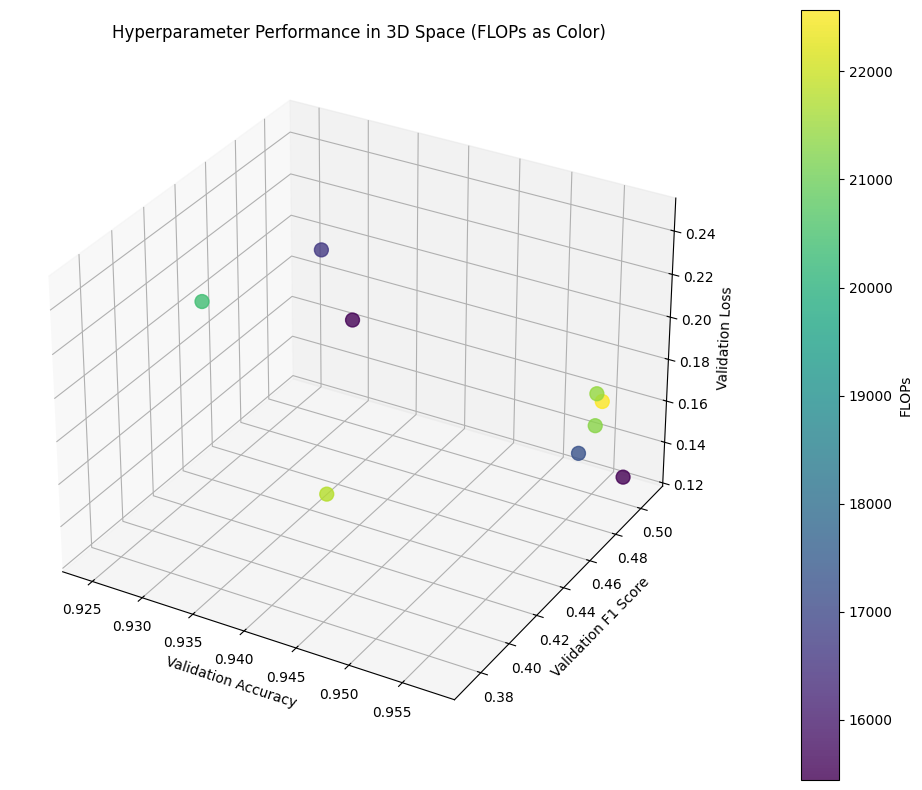

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and a 3D axes object
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D scatter plot
scatter = ax.scatter(accuracies, f1_scores, losses, c=flops_values, cmap='viridis', s=100, alpha=0.8)

# Label the axes
ax.set_xlabel('Validation Accuracy')
ax.set_ylabel('Validation F1 Score')
ax.set_zlabel('Validation Loss')

# Set the title of the plot
ax.set_title('Hyperparameter Performance in 3D Space (FLOPs as Color)')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('FLOPs')

# Display the plot
plt.show()

# Task
Prepare fitness data from `final_pop_stats` for Pareto dominance checking, considering accuracy, F1-score, negative loss, and negative FLOPs as objectives. Identify the Pareto front by determining which solutions are non-dominated. Extract the validation accuracy, F1-score, and loss values for these Pareto front solutions. Then, modify the existing 3D scatter plot in cell `072ca572` to visualize these Pareto front solutions with a distinct color and line connections, updating the plot title and legends as needed.

## Prepare Fitness Data for Pareto Front

### Subtask:
Convert the `final_pop_stats` (which are dictionaries) into a list of tuples, where each tuple represents the fitness objectives in a 'greater is better' format. This will include accuracy, F1-score, negative loss, and negative FLOPs, as expected for Pareto dominance checking.


**Reasoning**:
The subtask requires converting the dictionary-based fitness statistics into a list of tuples, applying the 'greater is better' principle by negating loss and FLOPs. This code block will perform the requested conversion and store the result in `fitness_data`.



In [35]:
fitness_data = []

for member_stats in final_pop_stats:
    accuracy = member_stats['val_accuracy']
    f1_score = member_stats['val_f1']
    loss = member_stats['val_loss']
    flops = member_stats['flops']

    # Negate loss and flops for 'greater is better' comparison
    if accuracy > 0.1:
      fitness_data.append((accuracy, f1_score, -loss, -flops))

print("Prepared fitness data for Pareto front (accuracy, f1_score, -loss, -flops):")
for item in fitness_data:
    print(item)

Prepared fitness data for Pareto front (accuracy, f1_score, -loss, -flops):
(0.924404061212478, 0.4401265466147506, -0.20360857248306274, -20372)
(0.954335883853247, 0.5067374974418285, -0.14682814478874207, -21306)
(0.957058073376496, 0.4841461662347973, -0.1793963462114334, -21454)
(0.9526804983323524, 0.5077579150679876, -0.1302846521139145, -17273)
(0.9571071218363744, 0.4882478091486355, -0.17338362336158752, -22568)
(0.9410805375711203, 0.4277931035772632, -0.22408072650432587, -15496)
(0.9465862271924662, 0.3716813772683896, -0.1858673244714737, -21769)
(0.9574014125956445, 0.505074798434789, -0.1271018236875534, -15444)
(0.937021777516186, 0.4354698188904643, -0.24635367095470428, -16644)


**Reasoning**:
Now that the fitness data is prepared, the next step is to implement the Pareto dominance check function to identify the non-dominated solutions. This function will be crucial for determining the Pareto front.



In [36]:
def is_dominated(p1, p2):
    """
    Checks if point p1 is dominated by point p2.
    A point p1 is dominated by p2 if p2 is better than or equal to p1 in all objectives,
    and strictly better in at least one objective.
    Assumes 'greater is better' for all objectives.
    """
    # Check if p2 is strictly better in at least one objective
    strictly_better = False
    for i in range(len(p1)):
        if p2[i] > p1[i]:
            strictly_better = True
        elif p2[i] < p1[i]: # p2 is worse than p1 in this objective, so p1 is not dominated by p2
            return False
    return strictly_better

def find_pareto_front(points):
    """
    Finds the Pareto front from a list of points (solutions).
    """
    pareto_front = []
    for i, p1 in enumerate(points):
        is_p1_dominated = False
        for j, p2 in enumerate(points):
            if i == j:
                continue
            if is_dominated(p1, p2):
                is_p1_dominated = True
                break
        if not is_p1_dominated:
            pareto_front.append(p1)
    return pareto_front

# Find the Pareto front using the prepared fitness data
pareto_solutions = find_pareto_front(fitness_data)

print("Pareto Front Solutions:")
for solution in pareto_solutions:
    print(solution)

Pareto Front Solutions:
(0.954335883853247, 0.5067374974418285, -0.14682814478874207, -21306)
(0.9526804983323524, 0.5077579150679876, -0.1302846521139145, -17273)
(0.9574014125956445, 0.505074798434789, -0.1271018236875534, -15444)


**Reasoning**:
Extract the accuracy, F1-score, and positive loss values from each Pareto front solution to prepare them for plotting.



In [37]:
pareto_accuracies = []
pareto_f1_scores = []
pareto_losses = []

for solution in pareto_solutions:
    # solution is (accuracy, f1_score, -loss, -flops)
    pareto_accuracies.append(solution[0])
    pareto_f1_scores.append(solution[1])
    pareto_losses.append(-solution[2]) # Negate back to positive loss

print("Pareto Front Accuracies:", pareto_accuracies)
print("Pareto Front F1 Scores:", pareto_f1_scores)
print("Pareto Front Losses:", pareto_losses)

Pareto Front Accuracies: [0.954335883853247, 0.9526804983323524, 0.9574014125956445]
Pareto Front F1 Scores: [0.5067374974418285, 0.5077579150679876, 0.505074798434789]
Pareto Front Losses: [0.14682814478874207, 0.1302846521139145, 0.1271018236875534]


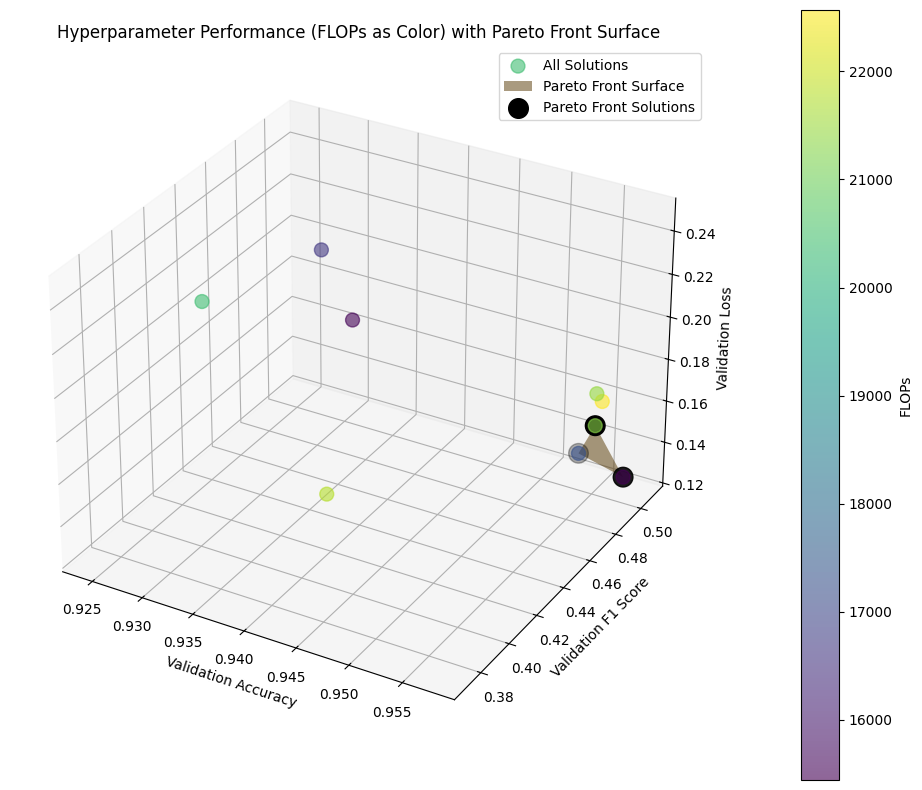

In [39]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all initial solutions as before
scatter = ax.scatter(accuracies, f1_scores, losses, c=flops_values, cmap='viridis', s=100, alpha=0.6, label='All Solutions')

# Create a triangulated surface for the Pareto front
# plot_trisurf can handle unsorted points and triangulate them
ax.plot_trisurf(pareto_accuracies, pareto_f1_scores, pareto_losses, color='orange', alpha=0.5, label='Pareto Front Surface')

# Highlight the individual Pareto front solutions with distinct scatter points
ax.scatter(pareto_accuracies, pareto_f1_scores, pareto_losses, color='black', s=200, marker='o', edgecolors='black', label='Pareto Front Solutions', zorder=10)

# Label the axes
ax.set_xlabel('Validation Accuracy')
ax.set_ylabel('Validation F1 Score')
ax.set_zlabel('Validation Loss')

# Set the title of the plot
ax.set_title('Hyperparameter Performance (FLOPs as Color) with Pareto Front Surface')

# Add a color bar for the scatter plot (all solutions) and set its label to 'FLOPs'
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('FLOPs')

# Add legend to distinguish all solutions from Pareto front solutions/surface
# The label from plot_trisurf might not appear in legend directly, so we explicitly add 'Pareto Front Solutions'
# For a true surface legend, a custom legend handle might be needed, but scatter for points is sufficient as requested.
ax.legend()

# Display the plot
plt.show()